In [1]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [2]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

<>:9: SyntaxWarning: invalid escape sequence '\h'
<>:9: SyntaxWarning: invalid escape sequence '\h'
C:\Users\giuli\AppData\Local\Temp\ipykernel_7080\4257064643.py:9: SyntaxWarning: invalid escape sequence '\h'
  """


In [3]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [ ]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


# Learn dictionary of MNIST images 

In [4]:
def display_dictionary(W, save_name=None, score=None, grid_shape=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    if grid_shape is not None:
        rows = grid_shape[0]
        cols = grid_shape[1]
    
    figsize0=(6, 6)
    if (score is None) and (grid_shape is not None):
       figsize0=(cols, rows)
    if (score is not None) and (grid_shape is not None):
       figsize0=(cols, rows+0.2)
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=figsize0,
                            subplot_kw={'xticks': [], 'yticks': []})
        
        
    for ax, i in zip(axs.flat, range(100)):
        if score is not None:
            idx = np.argsort(score)
            idx = np.flip(idx)    
            
            ax.imshow(W.T[idx[i]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
            ax.xaxis.set_label_coords(0.5, -0.05)
        else: 
            ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
            if score is not None:
                ax.set_xlabel('%1.2f' % score[i], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.05)
       
    plt.tight_layout()
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [5]:
def display_dictionary_list(W_list, label_list, save_name=None, score_list=None):
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=len(W_list)
    fig = plt.figure(figsize=(16, 5), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    
    
    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        sub_rows = int(np.sqrt(W_list[i].shape[1]))
        sub_cols = int(np.sqrt(W_list[i].shape[1]))

        idx = np.arange(W_list[i].shape[1])
        if score_list is not None:
            idx = np.argsort(score_list[i])
            idx = np.flip(idx)    
        
        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j // sub_cols 
            b = j % sub_cols #sub-lattice indices

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[idx[j]].reshape(k, k), cmap="viridis", interpolation='nearest')
            ax.set_xticks([])
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
            if (score_list is not None) and (score_list[i] is not None):
                ax.set_xlabel('%1.2f' % score_list[i][idx[j]], fontsize=13)  # get the largest first
                ax.xaxis.set_label_coords(0.5, -0.07)
           
                
                
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig(save_name, bbox_inches='tight')

In [8]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

In [ ]:
# Unconstrained matrix factorization and dictionary images 

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

In [ ]:
# PCA and dictionary images (principal components)

pca = PCA(n_components=24)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "MNIST_PCA_ex1.pdf", grid_shape=[1,24])

  1%|          | 1/100 [00:00<00:32,  3.09it/s]

iteration 0, reconstruction error 6245.872309


 11%|█         | 11/100 [00:02<00:20,  4.42it/s]

iteration 10, reconstruction error 1748.141436


 21%|██        | 21/100 [00:04<00:16,  4.79it/s]

iteration 20, reconstruction error 1415.269012


 31%|███       | 31/100 [00:07<00:15,  4.42it/s]

iteration 30, reconstruction error 1272.437453


 41%|████      | 41/100 [00:09<00:13,  4.36it/s]

iteration 40, reconstruction error 1199.261476


 51%|█████     | 51/100 [00:11<00:12,  4.04it/s]

iteration 50, reconstruction error 1155.897831


 61%|██████    | 61/100 [00:14<00:09,  4.23it/s]

iteration 60, reconstruction error 1126.595279


 71%|███████   | 71/100 [00:16<00:06,  4.42it/s]

iteration 70, reconstruction error 1105.770445


 81%|████████  | 81/100 [00:19<00:04,  4.12it/s]

iteration 80, reconstruction error 1091.422528


 91%|█████████ | 91/100 [00:22<00:02,  3.02it/s]

iteration 90, reconstruction error 1081.377188


  1%|          | 1/100 [00:00<00:22,  4.36it/s]

iteration 0, reconstruction error 4772.688940


 11%|█         | 11/100 [00:02<00:19,  4.55it/s]

iteration 10, reconstruction error 1472.254261


 21%|██        | 21/100 [00:04<00:17,  4.56it/s]

iteration 20, reconstruction error 1101.797526


 31%|███       | 31/100 [00:07<00:15,  4.57it/s]

iteration 30, reconstruction error 994.811714


 41%|████      | 41/100 [00:09<00:12,  4.60it/s]

iteration 40, reconstruction error 953.512794


 51%|█████     | 51/100 [00:11<00:10,  4.69it/s]

iteration 50, reconstruction error 932.202121


 61%|██████    | 61/100 [00:13<00:08,  4.68it/s]

iteration 60, reconstruction error 921.357794


 71%|███████   | 71/100 [00:15<00:06,  4.73it/s]

iteration 70, reconstruction error 915.784888


 81%|████████  | 81/100 [00:18<00:04,  4.70it/s]

iteration 80, reconstruction error 912.768946


 91%|█████████ | 91/100 [00:20<00:01,  4.68it/s]

iteration 90, reconstruction error 911.011710


  1%|          | 1/100 [00:00<00:22,  4.32it/s]

iteration 0, reconstruction error 4841.886614


 11%|█         | 11/100 [00:02<00:19,  4.68it/s]

iteration 10, reconstruction error 2049.348117


 21%|██        | 21/100 [00:04<00:17,  4.57it/s]

iteration 20, reconstruction error 1777.002230


 31%|███       | 31/100 [00:06<00:15,  4.57it/s]

iteration 30, reconstruction error 1674.742153


 41%|████      | 41/100 [00:08<00:12,  4.67it/s]

iteration 40, reconstruction error 1604.339799


 51%|█████     | 51/100 [00:11<00:10,  4.50it/s]

iteration 50, reconstruction error 1519.320172


 61%|██████    | 61/100 [00:13<00:09,  4.29it/s]

iteration 60, reconstruction error 1481.754572


 71%|███████   | 71/100 [00:15<00:06,  4.43it/s]

iteration 70, reconstruction error 1438.620535


 81%|████████  | 81/100 [00:19<00:06,  3.08it/s]

iteration 80, reconstruction error 1433.688411


 91%|█████████ | 91/100 [00:21<00:02,  4.28it/s]

iteration 90, reconstruction error 1431.430702


100%|██████████| 100/100 [00:24<00:00,  4.15it/s]


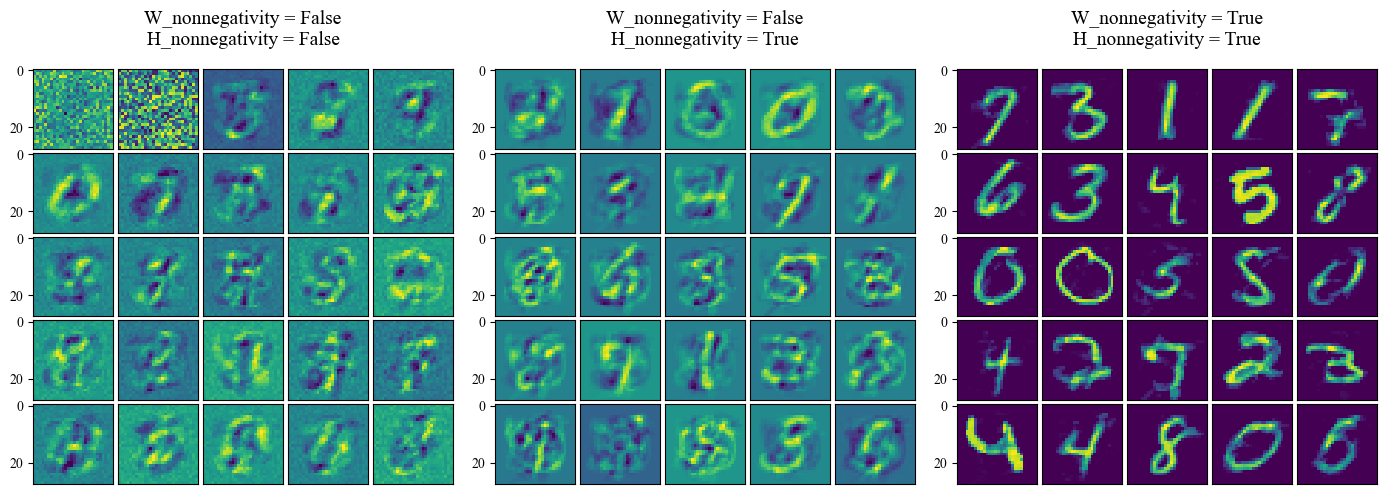

In [13]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")



In [ ]:
# MF and PCA on MNIST

idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex1.pdf")



In [6]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [7]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

NameError: name 'X' is not defined

  1%|          | 1/100 [00:00<00:43,  2.26it/s]

iteration 0, reconstruction error 12569.528089


 11%|█         | 11/100 [00:04<00:32,  2.74it/s]

iteration 10, reconstruction error 4477.334435


 21%|██        | 21/100 [00:07<00:30,  2.60it/s]

iteration 20, reconstruction error 3727.327535


 31%|███       | 31/100 [00:11<00:25,  2.72it/s]

iteration 30, reconstruction error 3353.134700


 41%|████      | 41/100 [00:15<00:20,  2.81it/s]

iteration 40, reconstruction error 3138.492777


 51%|█████     | 51/100 [00:18<00:17,  2.75it/s]

iteration 50, reconstruction error 3002.552858


 61%|██████    | 61/100 [00:23<00:19,  1.96it/s]

iteration 60, reconstruction error 2918.938987


 71%|███████   | 71/100 [00:28<00:13,  2.15it/s]

iteration 70, reconstruction error 2863.676005


 81%|████████  | 81/100 [00:32<00:08,  2.32it/s]

iteration 80, reconstruction error 2823.723750


 91%|█████████ | 91/100 [00:36<00:03,  2.57it/s]

iteration 90, reconstruction error 2792.111610


  1%|          | 1/100 [00:00<00:41,  2.40it/s]

iteration 0, reconstruction error 7773.223823


 11%|█         | 11/100 [00:04<00:36,  2.44it/s]

iteration 10, reconstruction error 4363.261883


 21%|██        | 21/100 [00:09<00:36,  2.18it/s]

iteration 20, reconstruction error 3510.282792


 31%|███       | 31/100 [00:13<00:26,  2.57it/s]

iteration 30, reconstruction error 2867.309612


 41%|████      | 41/100 [00:17<00:22,  2.57it/s]

iteration 40, reconstruction error 2577.020001


 51%|█████     | 51/100 [00:23<00:30,  1.59it/s]

iteration 50, reconstruction error 2495.799118


 61%|██████    | 61/100 [00:28<00:16,  2.35it/s]

iteration 60, reconstruction error 2457.256187


 71%|███████   | 71/100 [00:32<00:11,  2.45it/s]

iteration 70, reconstruction error 2432.746638


 81%|████████  | 81/100 [00:36<00:07,  2.58it/s]

iteration 80, reconstruction error 2415.474712


 91%|█████████ | 91/100 [00:40<00:03,  2.36it/s]

iteration 90, reconstruction error 2403.167091


  1%|          | 1/100 [00:00<00:39,  2.50it/s]

iteration 0, reconstruction error 7768.884054


 11%|█         | 11/100 [00:04<00:37,  2.39it/s]

iteration 10, reconstruction error 4810.524223


 21%|██        | 21/100 [00:10<00:41,  1.88it/s]

iteration 20, reconstruction error 4448.328858


 31%|███       | 31/100 [00:16<00:34,  2.03it/s]

iteration 30, reconstruction error 4060.604020


 41%|████      | 41/100 [00:20<00:23,  2.47it/s]

iteration 40, reconstruction error 3685.075322


 51%|█████     | 51/100 [00:24<00:19,  2.53it/s]

iteration 50, reconstruction error 3442.077134


 61%|██████    | 61/100 [00:28<00:15,  2.54it/s]

iteration 60, reconstruction error 3390.549961


 71%|███████   | 71/100 [00:32<00:12,  2.41it/s]

iteration 70, reconstruction error 3333.095259


 81%|████████  | 81/100 [00:36<00:07,  2.50it/s]

iteration 80, reconstruction error 3284.980845


 91%|█████████ | 91/100 [00:40<00:03,  2.29it/s]

iteration 90, reconstruction error 3238.160394


100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


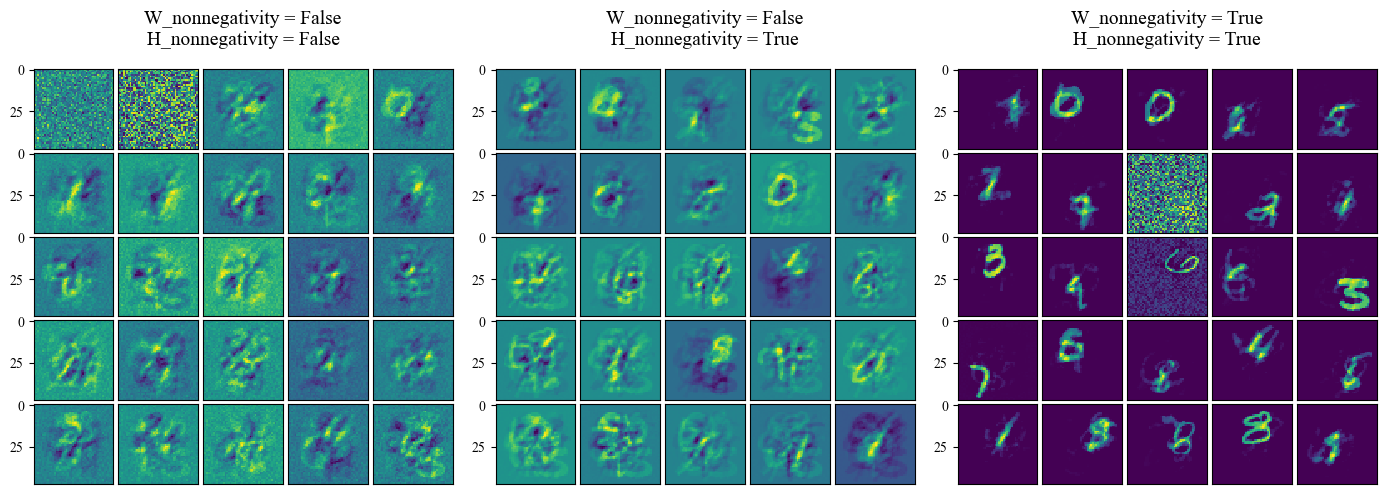

In [12]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

In [ ]:
# MF and PCA on MNIST + padding

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)



idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X_train[idx,:].T
n_iter = 100
W_list = []
H_list = []

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "MNIST_PCA_NMF_ex2.pdf")



## Dictionary Learing for Face datasets

In [7]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


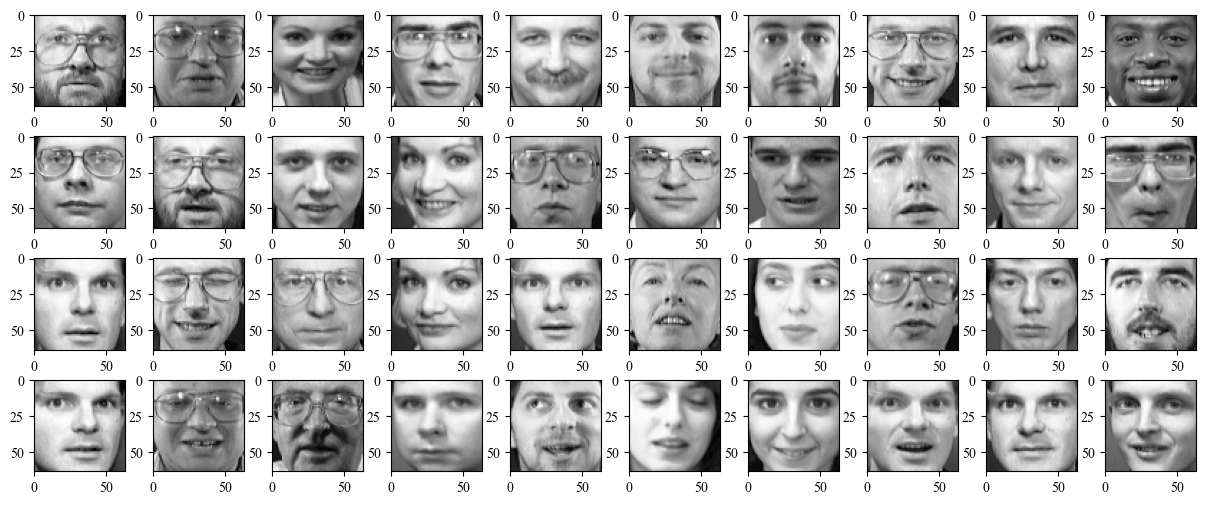

In [15]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

In [ ]:
# PCA and dictionary images (principal components)

X0 = faces.T
pca = PCA(n_components=24)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_

display_dictionary(W, score=s, save_name = "Faces_PCA_ex1.pdf", grid_shape=[2,12])

  0%|          | 1/200 [00:00<02:26,  1.36it/s]

iteration 0, reconstruction error 31474.621127


  6%|▌         | 11/200 [00:07<01:52,  1.68it/s]

iteration 10, reconstruction error 10.036038


 10%|█         | 21/200 [00:12<01:44,  1.71it/s]

iteration 20, reconstruction error 10.036038


 16%|█▌        | 31/200 [00:18<01:36,  1.75it/s]

iteration 30, reconstruction error 10.036038


 20%|██        | 41/200 [00:24<01:31,  1.75it/s]

iteration 40, reconstruction error 10.036038


 26%|██▌       | 51/200 [00:30<01:24,  1.75it/s]

iteration 50, reconstruction error 10.036038


 30%|███       | 61/200 [00:35<01:20,  1.73it/s]

iteration 60, reconstruction error 10.036038


 36%|███▌      | 71/200 [00:41<01:17,  1.67it/s]

iteration 70, reconstruction error 10.036038


 40%|████      | 81/200 [00:47<01:11,  1.66it/s]

iteration 80, reconstruction error 10.036038


 46%|████▌     | 91/200 [00:53<01:05,  1.66it/s]

iteration 90, reconstruction error 10.036038


 50%|█████     | 101/200 [01:00<00:59,  1.65it/s]

iteration 100, reconstruction error 10.036038


 56%|█████▌    | 111/200 [01:06<00:53,  1.66it/s]

iteration 110, reconstruction error 10.036038


 60%|██████    | 121/200 [01:12<00:48,  1.61it/s]

iteration 120, reconstruction error 10.036038


 66%|██████▌   | 131/200 [01:18<00:41,  1.66it/s]

iteration 130, reconstruction error 10.036038


 70%|███████   | 141/200 [01:24<00:36,  1.61it/s]

iteration 140, reconstruction error 10.036038


 76%|███████▌  | 151/200 [01:30<00:30,  1.60it/s]

iteration 150, reconstruction error 10.036038


 80%|████████  | 161/200 [01:37<00:24,  1.61it/s]

iteration 160, reconstruction error 10.036038


 86%|████████▌ | 171/200 [01:43<00:18,  1.60it/s]

iteration 170, reconstruction error 10.036038


 90%|█████████ | 181/200 [01:49<00:11,  1.62it/s]

iteration 180, reconstruction error 10.036038


 96%|█████████▌| 191/200 [01:55<00:05,  1.58it/s]

iteration 190, reconstruction error 10.036038


  0%|          | 1/200 [00:00<02:05,  1.59it/s]

iteration 0, reconstruction error 0.000013


  6%|▌         | 11/200 [00:09<02:16,  1.38it/s]

iteration 10, reconstruction error 0.000008


 10%|█         | 21/200 [00:15<01:48,  1.65it/s]

iteration 20, reconstruction error 0.000006


 16%|█▌        | 31/200 [00:21<01:47,  1.58it/s]

iteration 30, reconstruction error 0.000005


 20%|██        | 41/200 [00:28<01:51,  1.42it/s]

iteration 40, reconstruction error 0.000005


 26%|██▌       | 51/200 [00:34<01:31,  1.62it/s]

iteration 50, reconstruction error 0.000005


 30%|███       | 61/200 [00:40<01:23,  1.65it/s]

iteration 60, reconstruction error 0.000004


 36%|███▌      | 71/200 [00:46<01:17,  1.67it/s]

iteration 70, reconstruction error 0.000004


 40%|████      | 81/200 [00:52<01:13,  1.62it/s]

iteration 80, reconstruction error 0.000004


 46%|████▌     | 91/200 [00:58<01:05,  1.66it/s]

iteration 90, reconstruction error 0.000004


 50%|█████     | 101/200 [01:05<01:01,  1.61it/s]

iteration 100, reconstruction error 0.000004


 56%|█████▌    | 111/200 [01:11<00:55,  1.60it/s]

iteration 110, reconstruction error 0.000004


 60%|██████    | 121/200 [01:17<00:47,  1.65it/s]

iteration 120, reconstruction error 0.000004


 66%|██████▌   | 131/200 [01:23<00:42,  1.63it/s]

iteration 130, reconstruction error 0.000004


 70%|███████   | 141/200 [01:29<00:37,  1.58it/s]

iteration 140, reconstruction error 0.000004


 76%|███████▌  | 151/200 [01:36<00:31,  1.58it/s]

iteration 150, reconstruction error 0.000004


 80%|████████  | 161/200 [01:42<00:23,  1.66it/s]

iteration 160, reconstruction error 0.000004


 86%|████████▌ | 171/200 [01:48<00:17,  1.65it/s]

iteration 170, reconstruction error 0.000004


 90%|█████████ | 181/200 [01:54<00:11,  1.66it/s]

iteration 180, reconstruction error 0.000004


 96%|█████████▌| 191/200 [02:00<00:05,  1.65it/s]

iteration 190, reconstruction error 0.000004


  0%|          | 1/200 [00:00<02:00,  1.65it/s]

iteration 0, reconstruction error 0.000013


  6%|▌         | 11/200 [00:06<01:56,  1.62it/s]

iteration 10, reconstruction error 0.000007


 10%|█         | 21/200 [00:13<01:55,  1.54it/s]

iteration 20, reconstruction error 0.000006


 16%|█▌        | 31/200 [00:19<01:45,  1.61it/s]

iteration 30, reconstruction error 0.000005


 20%|██        | 41/200 [00:26<01:39,  1.60it/s]

iteration 40, reconstruction error 0.000005


 26%|██▌       | 51/200 [00:32<01:31,  1.64it/s]

iteration 50, reconstruction error 0.000005


 30%|███       | 61/200 [00:38<01:27,  1.58it/s]

iteration 60, reconstruction error 0.000004


 36%|███▌      | 71/200 [00:45<01:19,  1.63it/s]

iteration 70, reconstruction error 0.000004


 40%|████      | 81/200 [00:51<01:12,  1.65it/s]

iteration 80, reconstruction error 0.000004


 46%|████▌     | 91/200 [00:57<01:07,  1.62it/s]

iteration 90, reconstruction error 0.000004


 50%|█████     | 101/200 [01:03<01:00,  1.64it/s]

iteration 100, reconstruction error 0.000004


 56%|█████▌    | 111/200 [01:09<00:55,  1.60it/s]

iteration 110, reconstruction error 0.000004


 60%|██████    | 121/200 [01:15<00:48,  1.63it/s]

iteration 120, reconstruction error 0.000004


 66%|██████▌   | 131/200 [01:22<00:42,  1.61it/s]

iteration 130, reconstruction error 0.000004


 70%|███████   | 141/200 [01:28<00:36,  1.60it/s]

iteration 140, reconstruction error 0.000004


 76%|███████▌  | 151/200 [01:34<00:30,  1.63it/s]

iteration 150, reconstruction error 0.000004


 80%|████████  | 161/200 [01:40<00:23,  1.64it/s]

iteration 160, reconstruction error 0.000004


 86%|████████▌ | 171/200 [01:46<00:17,  1.62it/s]

iteration 170, reconstruction error 0.000004


 90%|█████████ | 181/200 [01:53<00:11,  1.63it/s]

iteration 180, reconstruction error 0.000004


 96%|█████████▌| 191/200 [01:59<00:05,  1.62it/s]

iteration 190, reconstruction error 0.000004


100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


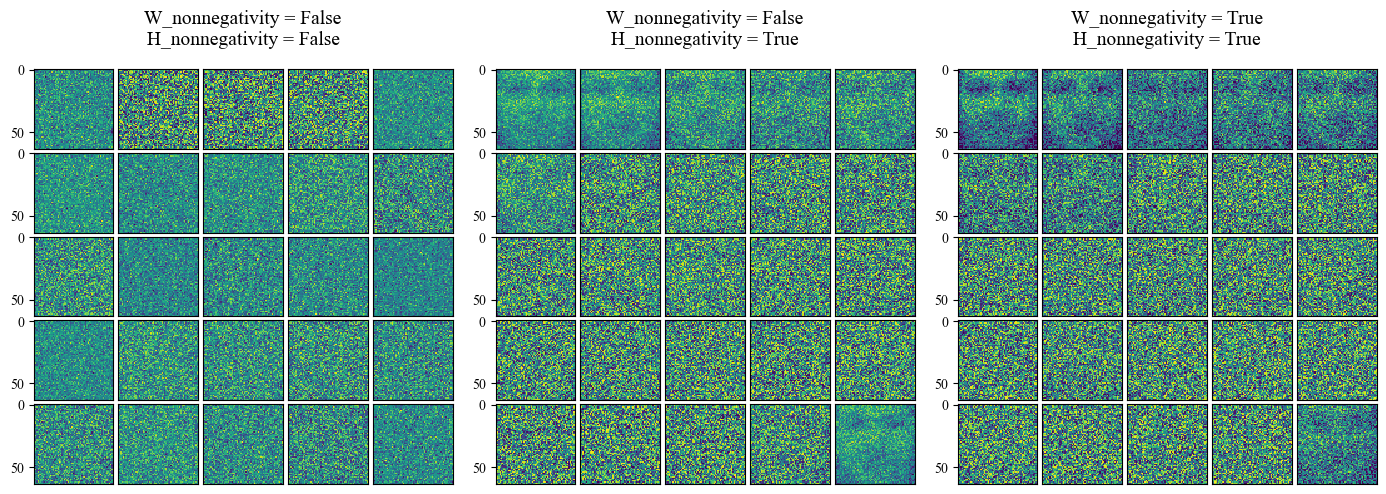

In [14]:
# Variable nonnegativity constraints 

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(nonnegativitiy)):
    label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex1.pdf")



In [ ]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

nonnegativitiy = ['PCA', [False, False], [False, True], [True, True]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)

label_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "H_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(nonnegativitiy)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex1.pdf")

X0.shape (4096, 400)


  0%|          | 1/200 [00:00<02:14,  1.48it/s]

iteration 0, reconstruction error 0.004026


  6%|▌         | 11/200 [00:07<01:55,  1.63it/s]

iteration 10, reconstruction error 0.000009


 10%|█         | 21/200 [00:13<01:49,  1.64it/s]

iteration 20, reconstruction error 0.000009


 16%|█▌        | 31/200 [00:19<01:42,  1.65it/s]

iteration 30, reconstruction error 0.000009


 20%|██        | 41/200 [00:25<01:34,  1.68it/s]

iteration 40, reconstruction error 0.000009


 26%|██▌       | 51/200 [00:31<01:30,  1.64it/s]

iteration 50, reconstruction error 0.000009


 30%|███       | 61/200 [00:37<01:24,  1.65it/s]

iteration 60, reconstruction error 0.000009


 36%|███▌      | 71/200 [00:44<01:23,  1.55it/s]

iteration 70, reconstruction error 0.000009


 40%|████      | 81/200 [00:50<01:16,  1.55it/s]

iteration 80, reconstruction error 0.000009


 46%|████▌     | 91/200 [00:57<01:09,  1.58it/s]

iteration 90, reconstruction error 0.000009


 50%|█████     | 101/200 [01:03<01:02,  1.59it/s]

iteration 100, reconstruction error 0.000009


 56%|█████▌    | 111/200 [01:09<00:55,  1.60it/s]

iteration 110, reconstruction error 0.000009


 60%|██████    | 121/200 [01:15<00:48,  1.62it/s]

iteration 120, reconstruction error 0.000009


 66%|██████▌   | 131/200 [01:21<00:42,  1.64it/s]

iteration 130, reconstruction error 0.000009


 70%|███████   | 141/200 [01:28<00:37,  1.57it/s]

iteration 140, reconstruction error 0.000009


 76%|███████▌  | 151/200 [01:34<00:30,  1.59it/s]

iteration 150, reconstruction error 0.000009


 80%|████████  | 161/200 [01:40<00:24,  1.61it/s]

iteration 160, reconstruction error 0.000009


 86%|████████▌ | 171/200 [01:47<00:18,  1.59it/s]

iteration 170, reconstruction error 0.000009


 90%|█████████ | 181/200 [01:53<00:11,  1.61it/s]

iteration 180, reconstruction error 0.000009


 96%|█████████▌| 191/200 [01:59<00:05,  1.59it/s]

iteration 190, reconstruction error 0.000009


  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\giuli\AppData\Local\Temp\ipykernel_14736\4257064643.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
  0%|          | 1/200 [00:00<01:59,  1.66it/s]

iteration 0, reconstruction error 0.000100


  6%|▌         | 11/200 [00:02<00:44,  4.23it/s]

iteration 10, reconstruction error 0.000100


 10%|█         | 21/200 [00:05<00:43,  4.10it/s]

iteration 20, reconstruction error 0.000100


 16%|█▌        | 31/200 [00:07<00:40,  4.22it/s]

iteration 30, reconstruction error 0.000100


 20%|██        | 41/200 [00:10<00:37,  4.25it/s]

iteration 40, reconstruction error 0.000100


 26%|██▌       | 51/200 [00:12<00:37,  4.00it/s]

iteration 50, reconstruction error 0.000100


 30%|███       | 61/200 [00:14<00:32,  4.25it/s]

iteration 60, reconstruction error 0.000100


 36%|███▌      | 71/200 [00:17<00:29,  4.30it/s]

iteration 70, reconstruction error 0.000100


 40%|████      | 81/200 [00:19<00:28,  4.20it/s]

iteration 80, reconstruction error 0.000100


 46%|████▌     | 91/200 [00:21<00:25,  4.31it/s]

iteration 90, reconstruction error 0.000100


 50%|█████     | 101/200 [00:24<00:24,  4.09it/s]

iteration 100, reconstruction error 0.000100


 56%|█████▌    | 111/200 [00:26<00:21,  4.23it/s]

iteration 110, reconstruction error 0.000100


 60%|██████    | 121/200 [00:28<00:18,  4.30it/s]

iteration 120, reconstruction error 0.000100


 66%|██████▌   | 131/200 [00:31<00:16,  4.26it/s]

iteration 130, reconstruction error 0.000100


 70%|███████   | 141/200 [00:33<00:13,  4.31it/s]

iteration 140, reconstruction error 0.000100


 76%|███████▌  | 151/200 [00:35<00:11,  4.31it/s]

iteration 150, reconstruction error 0.000100


 80%|████████  | 161/200 [00:38<00:09,  4.18it/s]

iteration 160, reconstruction error 0.000100


 86%|████████▌ | 171/200 [00:40<00:06,  4.20it/s]

iteration 170, reconstruction error 0.000100


 90%|█████████ | 181/200 [00:43<00:04,  3.82it/s]

iteration 180, reconstruction error 0.000100


 96%|█████████▌| 191/200 [00:45<00:02,  4.23it/s]

iteration 190, reconstruction error 0.000100


  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\giuli\AppData\Local\Temp\ipykernel_14736\4257064643.py:32: RuntimeWarning: invalid value encountered in scalar divide
  if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
  0%|          | 1/200 [00:00<01:33,  2.12it/s]

iteration 0, reconstruction error 0.000100


  6%|▌         | 11/200 [00:04<01:20,  2.36it/s]

iteration 10, reconstruction error 0.000100


 10%|█         | 21/200 [00:08<01:16,  2.35it/s]

iteration 20, reconstruction error 0.000100


 16%|█▌        | 31/200 [00:13<01:12,  2.33it/s]

iteration 30, reconstruction error 0.000100


 20%|██        | 41/200 [00:17<01:08,  2.33it/s]

iteration 40, reconstruction error 0.000100


 26%|██▌       | 51/200 [00:21<01:04,  2.30it/s]

iteration 50, reconstruction error 0.000100


 30%|███       | 61/200 [00:26<01:01,  2.27it/s]

iteration 60, reconstruction error 0.000100


 36%|███▌      | 71/200 [00:30<00:54,  2.35it/s]

iteration 70, reconstruction error 0.000100


 40%|████      | 81/200 [00:34<00:50,  2.34it/s]

iteration 80, reconstruction error 0.000100


 46%|████▌     | 91/200 [00:38<00:46,  2.32it/s]

iteration 90, reconstruction error 0.000100


 50%|█████     | 101/200 [00:43<00:42,  2.33it/s]

iteration 100, reconstruction error 0.000100


 56%|█████▌    | 111/200 [00:47<00:38,  2.33it/s]

iteration 110, reconstruction error 0.000100


 60%|██████    | 121/200 [00:51<00:34,  2.26it/s]

iteration 120, reconstruction error 0.000100


 66%|██████▌   | 131/200 [00:56<00:31,  2.16it/s]

iteration 130, reconstruction error 0.000100


 70%|███████   | 141/200 [01:00<00:25,  2.32it/s]

iteration 140, reconstruction error 0.000100


 76%|███████▌  | 151/200 [01:04<00:21,  2.33it/s]

iteration 150, reconstruction error 0.000100


 80%|████████  | 161/200 [01:09<00:16,  2.29it/s]

iteration 160, reconstruction error 0.000100


 86%|████████▌ | 171/200 [01:13<00:12,  2.28it/s]

iteration 170, reconstruction error 0.000100


 90%|█████████ | 181/200 [01:17<00:08,  2.31it/s]

iteration 180, reconstruction error 0.000100


 96%|█████████▌| 191/200 [01:22<00:04,  2.18it/s]

iteration 190, reconstruction error 0.000100


100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


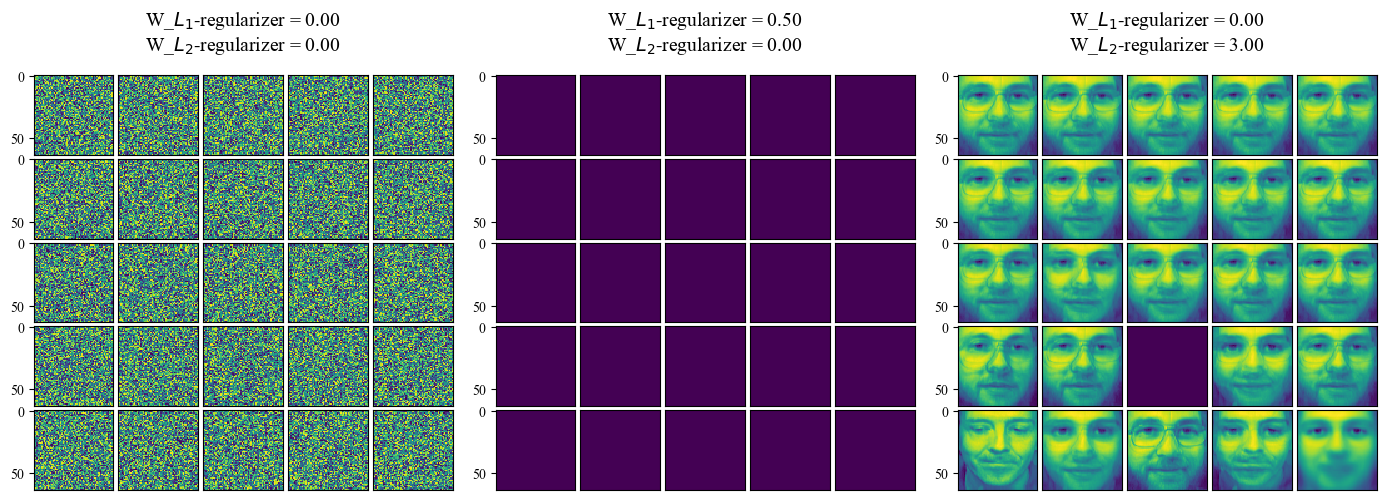

In [9]:
# Variable regularizer for W

X0 = faces.T
X0 /= 100 * np.linalg.norm(X0)
print('X0.shape', X0.shape)

n_iter = 200
W_list = []

W_sparsity = [[0, 0], [0.5, 0], [0, 3]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

In [ ]:
n_iter = 200
W_list = []
H_list = []

X0 = faces.T
#X0 /= 100 * np.linalg.norm(X0)

W_sparsity = ['PCA', [0, 0], [0.5, 0], [0, 3]]

#PCA 
pca = PCA(n_components=25)
pca.fit(X0.T)
W = pca.components_.T
s = pca.singular_values_
W_list.append(W)
H_list.append(s)

# MF
for i in np.arange(1,len(nonnegativitiy)): 
    print('!!! nonnegativitiy[i]', nonnegativitiy[i])
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    H_list.append(H)


label_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        label = nonnegativitiy[0]
    else:
        label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)
    
score_list = []
for i in np.arange(len(W_sparsity)):
    if i == 0:
        score_list.append(H_list[0])
    else:
        H = H_list[i]
        score = np.sum(abs(H), axis=1) # sum of the coefficients of each columns of W = overall usage 
        score_list.append(score)
    
display_dictionary_list(W_list=W_list, 
                        label_list = label_list, 
                        score_list = score_list,
                        save_name = "Faces_PCA_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [7]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [8]:
def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [10]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.electronics',
     'sci.med',
     'sci.space',
     'talk.politics.misc'
     ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

len(newsgroups_labels) 5785
newsgroups_labels [8 5 2 ... 5 9 6]
data_cleaned[1] 
Gee, you'd think Winnipeg would be tops on that list, what with  regulars
being European.



Well, being a Jet fan, I sometimes wish that Bure would get knocked silly
too.  (Nothing serious, just enough to keep him out of a game. :)



In most cases, the owners have very little to do with it.  They give their
general managers one order when it comes to the draft...find me the best
players so that our team will win the Stanley Cup.  Whether that player is
in Kindersley, Saskatchewan or Chelyabinsk, Russia, if the GM believes him
to be the better player, the GM should be drafting him.

Where do you get off calling the NHL THEIR league, when referring to Canadian
players.  It doesn't belong to them, it belongs to the owners.  The owners
can do what they want.  While a 'Canadian content' rule might be enforcable
here in Canada, there is enough doubt that it would be enforcable in the US
that the CFL (sorry for

In [13]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names_out())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

>>>> vectors.shape (40719, 5785)
newsgroups_labels[i] 4
>>>> data_cleaned[i] 
The Chicago Tribune pitching form has Perez pitching today (/).  But
given the way that Buck changes his rotation so often, that could just be
the work of a confused stat-page editor.


          Coordinate  Bag-of-words    tf-idf
buck            4829             1  0.259425
changes         5975             1  0.204166
chicago         6157             1  0.199448
confused        7458             1  0.238299
editor         11226             1  0.244160
form           13758             1  0.194164
given          14765             1  0.170696
often          25166             1  0.183690
page           25984             1  0.216991
perez          26604             1  0.297253
pitching       27154             2  0.437871
rotation       31034             1  0.239403
stat           34224             1  0.265467
today          36568             1  0.177456
tribune        37077             1  0.335697
way            3

C:\Users\giuli\AppData\Local\Temp\ipykernel_7080\1931396107.py:31: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  d[cols] = d[cols].applymap(np.int64)


In [15]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'rec.sport.hockey',
     'sci.electronics',
     'sci.med',
     'sci.space',
     'talk.politics.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names_out())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2,3,4,5,6,7,8,9], 
                                                                       vectorizer = 'tf-idf',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
#print('y_list', onehot2list(y_test))

!! X.shape (5785, 40719)
X_train.shape (4638, 40719)
X_test.shape (1147, 40719)
y_train.shape (4638, 10)
y_test.shape (1147, 10)
y_test [[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [16]:
idx2word = data_dict.get('idx2word')
categories = data_dict.get('categories')

In [17]:
import random 

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


def plot_topic_wordcloud(W, idx2word, num_keywords_in_topic=5, save_name=None, grid_shape = [2,5]):
        # plot the class-conditioanl PMF as wordclouds 
        # W = (p x r) (words x topic)
        # idx2words = list of words used in the vectorization of documents 
        # categories = list of class labels
        # prior on class labels = empirical PMF = [ # class i examples / total ]
        # class-conditional for class i = [ # word j in class i examples / # words in class i examples]
             
        fig, axs = plt.subplots(nrows=grid_shape[0], ncols=grid_shape[1], figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': []})
        for ax, i in zip(axs.flat, np.arange(W.shape[1])):
            # dist = W[:,i]/np.sum(W[:,i])

            ### Take top k keywords in each topic (top k coordinates in each column of W)
            ### to generate text data corresponding to the ith topic, and then generate its wordcloud
            list_words = []
        
            idx = np.argsort(W[:,i])
            idx = np.flip(idx)    
           
            for j in range(num_keywords_in_topic):
                list_words.append(idx2word[idx[j]])
                
            Y = " ".join(list_words)
            #stopwords = STOPWORDS
            #stopwords.update(["’", "“", "”", "000", "000 000", "https", "co", "19", "2019", "coronavirus",
            #                  "virus", "corona", "covid", "ncov", "covid19", "amp"])
            wc = WordCloud(background_color="black",
                                  relative_scaling=0,
                                  width=400,
                                  height=400).generate(Y)
            
            ax.imshow(wc.recolor(color_func=grey_color_func, random_state=3),
                                 interpolation="bilinear")
            
            # ax.set_xlabel(categories[i], fontsize='20')
            # ax.axis("off")

        plt.tight_layout()
        plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.08)
        if save_name is not None:
            plt.savefig(save_name, bbox_inches='tight')

X0.shape (40719, 4638)


  5%|▌         | 1/20 [00:19<06:12, 19.60s/it]

iteration 0, reconstruction error 1353367.038943


 55%|█████▌    | 11/20 [02:18<01:52, 12.53s/it]

iteration 10, reconstruction error 816398.378097


100%|██████████| 20/20 [04:04<00:00, 12.24s/it]


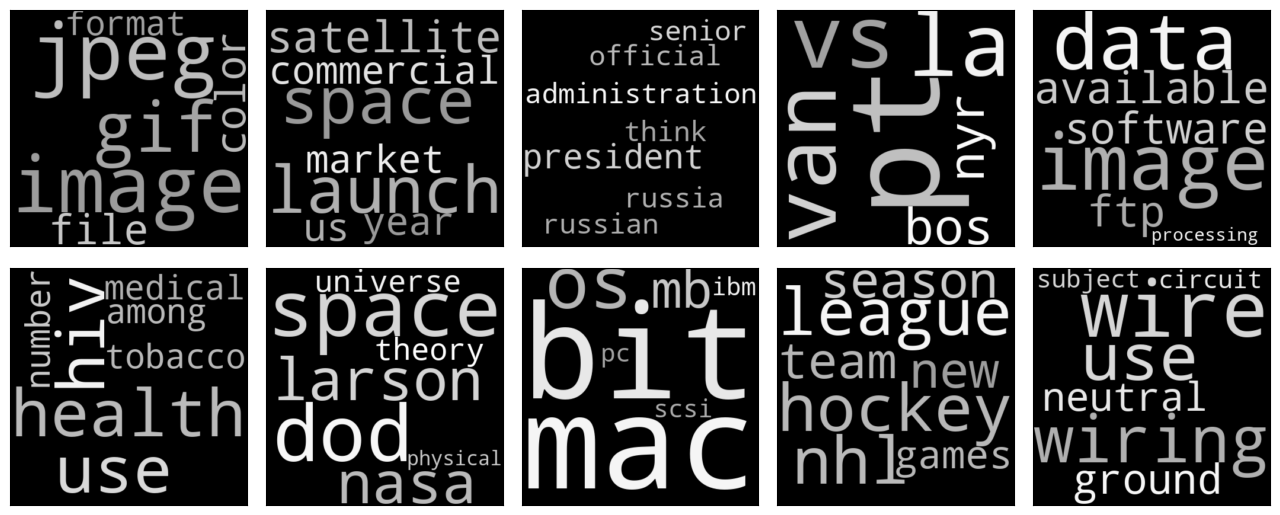

In [18]:
X0 = X_train.T

print('X0.shape', X0.shape)

W, H = ALS(X=X0, 
           n_components=10, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=True,
           compute_recons_error=True)

plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, grid_shape=[2,5], save_name="20NEWS_topic1.pdf")

In [ ]:
# Topic modeling by NMF
X0 = X_train.T

W, H = ALS(X=X0, 
           n_components=10, 
           n_iter=20, 
           subsample_ratio=1, 
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           W_nonnegativity=True,
           H_nonnegativity=False,
           compute_recons_error=True)


plot_topic_wordcloud(W, idx2word=idx2word, num_keywords_in_topic=7, grid_shape = [2,5], save_name="20NEWS_topic2.pdf")

## EM algorithm for PCA

In [14]:
# Gram-Schmidt Orthogonalization of a given matrix

def orthogonalize(U, eps=1e-15):
    """
    Orthogonalizes the matrix U (d x n) using Gram-Schmidt Orthogonalization.
    If the columns of U are linearly dependent with rank(U) = r, the last n-r columns 
    will be 0.
    
    Args:
        U (numpy.array): A d x n matrix with columns that need to be orthogonalized.
        eps (float): Threshold value below which numbers are regarded as 0 (default=1e-15).
    
    Returns:
        (numpy.array): A d x n orthogonal matrix. If the input matrix U's cols were
            not linearly independent, then the last n-r cols are zeros.
    """
    
    n = len(U[0])
    # numpy can readily reference rows using indices, but referencing full rows is a little
    # dirty. So, work with transpose(U)
    V = U.T
    for i in range(n):
        prev_basis = V[0:i]     # orthonormal basis before V[i]
        coeff_vec = np.dot(prev_basis, V[i].T)  # each entry is np.dot(V[j], V[i]) for all j < i
        # subtract projections of V[i] onto already determined basis V[0:i]
        V[i] -= np.dot(coeff_vec, prev_basis).T
        if np.linalg.norm(V[i]) < eps:
            V[i][V[i] < eps] = 0.   # set the small entries to 0
        else:
            V[i] /= np.linalg.norm(V[i])
    return V.T

# Example:
A = np.random.rand(2,2)
print('A \n', A)
print('orthogonalize(A) \n', orthogonalize(A))
print('A.T @ A \n', A.T @ A)

A 
 [[0.79977368 0.97263647]
 [0.58008226 0.64514502]]
orthogonalize(A) 
 [[ 0.80949194  0.58713099]
 [ 0.58713099 -0.80949194]]
A.T @ A 
 [[1.00000000e+00 5.55111512e-17]
 [5.55111512e-17 1.00000000e+00]]


In [330]:
def EM_PCA(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=10,
        W_ini=None,
        subsample_ratio=1,
        n_workers = 1):
    
        '''
        Given data matrix X of shape (d x n), compute its rank r=n_components PCA:
            \hat{W} = \argmax_{W} var(Proj_{W}(X)) 
                    = \argmin_{W} || X - Proj_{W}(X) ||_{F}^{2}
        where W is an (d x r) matrix of rank r. 
        '''
        
        d, n = X.shape
        r = n_components
        
        X_mean = np.mean(X, axis=1).reshape(-1,1)
        X_centered = X - np.repeat(X_mean, X0.shape[1], axis=1)
        print('subsample_size:', n//subsample_ratio)
        
        # Initialize factors 
        W_list = []
        loss_list = []
        
        
        for i in trange(n_workers):
            W = np.random.rand(d,r)
            if W_ini is not None:
                W = W_ini
                
            A = np.zeros(shape=[r, n//subsample_ratio]) # aggregate matrix for code H
          
            # Perform EM updates
            for j in np.arange(n_iter):
                idx_data = np.random.choice(np.arange(X.shape[1]), X.shape[1]//subsample_ratio, replace=False)
                X1 = X_centered[:,idx_data]
                H = np.linalg.inv(W.T @ W) @ (W.T @ X1) # E-step
                # A = (1-(1/(j+1)))*A + (1/(j+1))*H # Aggregation 
                W = X1 @ H.T @ np.linalg.inv(H @ H.T) # M-step
                # W = X1 @ A.T @ np.linalg.inv(A @ A.T) # M-step
            
                # W = orthogonalize(W)
                #if compute_recons_error and (j > n_iter-2) :   
                #    print('iteration %i, reconstruction error %f' % (j, np.linalg.norm(X_centered-W@(W.T @ X_centered))))

            W_list.append(W.copy())
            loss_list.append(np.linalg.norm(X_centered-W@(W.T @ X_centered)))
        
        idx = np.argsort(loss_list)[0]
        W = W_list[idx]
        print('loss_list',np.asarray(loss_list)[np.argsort(loss_list)])
        
        return orthogonalize(W)

In [331]:
# Load Olivetti Face dataset

from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)



  0%|          | 0/10 [00:00<?, ?it/s]

subsample_size: 200


100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


loss_list [2.02115047e+21 1.06369229e+22 1.11602314e+22 5.44586619e+22
 9.66356971e+22 1.02005484e+23 2.35972993e+23 3.73003644e+23
 2.92031550e+25 1.97717256e+26]


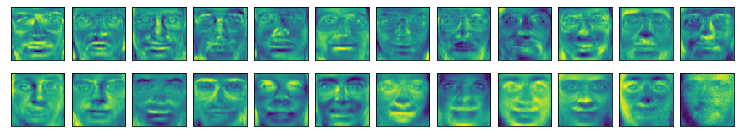

(cov @ W)[:,0] / W[:,0] [0.10126177 0.03221299 0.03781338 ... 1.83590729 0.22831967 0.13795046]
var coeff 7.056753261198149
var coeff exact 7.71901427541159e-05


In [332]:
# EM_PCA and dictionary images (principal components)

X0 = faces.T
W = EM_PCA(X0, W_ini = None, n_workers=10, n_iter=200, subsample_ratio=2, n_components=24)

display_dictionary(W, score=None, save_name = "Faces_EM_PCA_ex1.pdf", grid_shape=[2,12])

cov = np.cov(X0)
print('(cov @ W)[:,0] / W[:,0]', (cov @ W)[:,0] / W0[:,0])
print('var coeff', np.std((cov @ W)[:,0] / W[:,0]))
print('var coeff exact', np.std((cov @ W0)[:,0] / W0[:,0]))

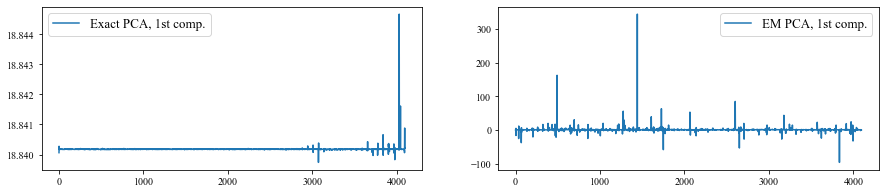

In [333]:
# plot coefficients of Cov @ W / W for exact PCA and EM PCA

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

pca = PCA(n_components=24)
pca.fit(X0.T)
W0 = pca.components_.T

axs[0].plot((cov @ W0)[:,0] / W0[:,0], label='Exact PCA, 1st comp.')
axs[0].legend(fontsize=13)
axs[1].plot((cov @ W)[:,0] / W[:,0], label='EM PCA, 1st comp.')
axs[1].legend(fontsize=13)
plt.savefig("EM_PCA_coeff_plot1.pdf", bbox_inches='tight')

(cov @ W)[:,0] / W[:,0] [18.83995064 18.84015752 18.84016132 ... 18.83869301 18.84011596
 18.84011793]


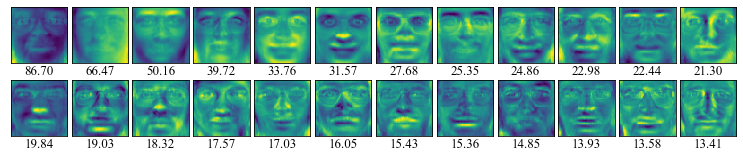

In [156]:
X0 = faces.T
pca = PCA(n_components=24)
pca.fit(X0.T)
W0 = pca.components_.T
s = pca.singular_values_
cov = np.cov(X0)
print('(cov @ W)[:,0] / W[:,0]', (cov @ W0)[:,0] / W0[:,0])

display_dictionary(W0, score=s, save_name = "Faces_PCA_ex1.pdf", grid_shape=[2,12])

In [43]:
X_mean = np.sum(X0, axis=1).reshape(-1,1)/X0.shape[1]
X_centered = X0 - np.repeat(X_mean, X0.shape[1], axis=1)
Cov = (X_centered @ X_centered.T) / X0.shape[1]

In [44]:
(Cov @ W)[:,0] / W[:,0]

array([  6.18676271,   5.72164269,   6.50310424, ...,  -3.55935514,
       -15.69828382, -42.1754618 ])

In [45]:
cov = np.cov(X0)
(cov @ W0)[:,0] / W0[:,0]

array([18.84005017, 18.84018314, 18.84018608, ..., 18.83973322,
       18.84014773, 18.84014791])

In [ ]:
np.real(eig_val[0])

In [ ]:
np.sort(np.real(eig_val))

In [ ]:
x = np.array([
        [0.387,4878, 5.42],
        [0.723,12104,5.25],
        [1,12756,5.52],
        [1.524,6787,3.94],
    ])

#centering the data
x0 =  x - np.mean(x, axis = 0)  

cov = np.cov(x0, rowvar = False)
print('cov', cov)
print('cov', np.cov(x, rowvar = False))

evals , evecs = np.linalg.eigh(cov)

In [ ]:
evals